In [ ]:
#| default_exp t2s_up_wds_mlang_enclm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| exporti
import dataclasses
import random
import math
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import record_function

from huggingface_hub import hf_hub_download
from fastcore.basics import store_attr
from fastprogress import progress_bar

from pathlib import Path

In [ ]:
#| exporti
from whisperspeech.modules import *
from whisperspeech import languages

In [ ]:
from whisperspeech.wer_metrics import *
from whisperspeech.train import *

from fastprogress import master_bar
import webdataset as wds

# Text to semantic tokens model

Multi-GPU training example:

    python3 -m whisperspeech.train_multi \
        --task "t2s_up_wds base --frozen_embeddings_model vqmodel-256c-dim64-4e-hyptuned-32gpu.model" \
        --input-dir "whisperspeech-t2s-512c-dim64/*.tar.gz 600000 --vq_codes=513"
        --batch-size 32 --epochs 1 \
        --tunables=--cps_input

# Dataset

In [ ]:
#| exporti
import re

class CharTokenizer:
    """Trivial tokenizer – just use UTF-8 bytes"""
    eot = 0
    
    def encode(self, txt):
        return list(bytes(txt.strip(), 'utf-8'))

    def decode(self, tokens):
        return bytes(tokens).decode('utf-8')
    
def tokenizer(ikey, okey, length):
    """Tokenizes a transcript"""
    tok = CharTokenizer()
    def _tokenizer(samples):
        for s in samples:
            toks = torch.tensor(tok.encode(s[ikey]))
            s[okey] = F.pad(toks, (0, length - toks.shape[-1]), value=tok.eot)
            yield s
    return _tokenizer

def ar_padder(ikey, okey, length, pad_token):
    """Pads the tokens for autoregresive training"""
    import numpy as np

    def _ar_padder(samples):
        for s in samples:
            toks = s[ikey]
            if isinstance(toks, (list, np.ndarray)): toks = torch.tensor(toks)
            toks = toks.to(torch.long)
            s['in_' +okey] = F.pad(toks, (1, length - toks.shape[-1] - 1), value=pad_token)
            s['out_'+okey] = F.pad(toks, (0, length - toks.shape[-1]), value=pad_token)
            yield s
    return _ar_padder

def char_per_seconder(txt_key, stoks_key, cps_key, stoks_per_second=25):
    """Adds the characters per second metric to the input data"""
    def _char_per_seconder(samples):
        for s in samples:
            secs = s[stoks_key].shape[-1] / stoks_per_second
            s[cps_key] = len(s[txt_key]) / secs
            yield s
    return _char_per_seconder

In [ ]:
#| export
def load_dataset(
    txt_shard_spec:str,    # transcription webdataset shards
    stoks_shard_dir:str,   # stoks webdataset base dir
    samples:int,           # samples per epoch
    txt_kind:str='small.en-txt',
    vq_codes:int=4096,
    language:str='en',
    weight:float=1,
    validation:bool=False,
    exclude_files:str=None,
):
    import webdataset as wds
    from whisperspeech import utils

    shards = utils.shard_glob(txt_shard_spec)
    excludes = {x for file in exclude_files.split() for x in utils.readlines(file)} if exclude_files else set()
    
    language = languages.to_id(language)
    
    def set_language(x):
        x['language'] = language
        return x
    
    same_on_all_nodes = lambda urls: urls # will only be used for validation
    ds = wds.WebDataset(shards, resampled=not validation, nodesplitter=same_on_all_nodes).compose(
        wds.decode(),
        utils.merge_in(utils.derived_dataset('eqvad-stoks', base=txt_kind, suffix='', dir=stoks_shard_dir)),
        # discard validation samples, select samples > .5s
        wds.select(lambda s: s['__key__'] not in excludes and s['stoks.npy'].shape[-1] > 12),
        tokenizer('txt', 'ttoks', length=550),
        ar_padder('stoks.npy', 'stoks', length=750, pad_token=vq_codes-1),
        ar_padder('ttoks', 'ttoks', length=550, pad_token=CharTokenizer.eot),
        char_per_seconder('txt', 'stoks.npy', 'cps', stoks_per_second=25),
        wds.map(set_language),
        wds.to_tuple('in_ttoks', 'out_ttoks', 'language', 'cps', 'in_stoks', 'out_stoks'),
        wds.shuffle(20000, initial=20000),
        wds.batched(64)
    )
    if validation:
        ds = ds.slice(samples // 64)
    ds.total_samples = samples
    ds.stoks_len = 750
    ds.stoks_codes = vq_codes
    ds.ttoks_len = 550
    ds.weight = weight

    return ds

In [ ]:
%pdb

Automatic pdb calling has been turned OFF


In [ ]:
train_ds = load_dataset('../wolnelektury-wds2/wolnelektury-medium-txt-*.tar.gz', '../wolnelektury-vqv2/', 190000,
                        txt_kind='medium-txt', vq_codes=512, language='pl',
                        exclude_files='../wolnelektury-wds2/validation-samples')
val_ds = load_dataset('../wolnelektury-wds2/validation-eqvad.tar.gz', '../wolnelektury-vqv2/', 520,
                      txt_kind='medium-txt', vq_codes=512, language='pl', validation=True)

In [ ]:
train_ds = load_dataset('../librilight/librilight-medium-small.en-txt-*.tar.gz', '../librilight-vq-en+pl/', 190000,
                        txt_kind='small.en-txt', vq_codes=512, language='en',
                        exclude_files='')
val_ds = load_dataset('../librilight/librilight-medium-small.en-txt-000000.tar.gz', '../librilight-vq-en+pl/', 512,
                      txt_kind='small.en-txt', vq_codes=512, language='en', validation=True)

In [ ]:
for x in progress_bar(train_ds, total=100): pass
x

[tensor([[  0,  83, 117,  ...,   0,   0,   0],
         [  0,  73, 102,  ...,   0,   0,   0],
         [  0,  72, 111,  ...,   0,   0,   0],
         ...,
         [  0,  70, 111,  ...,   0,   0,   0],
         [  0,  83, 105,  ...,   0,   0,   0],
         [  0,  97, 110,  ...,   0,   0,   0]]),
 tensor([[ 83, 117,  99,  ...,   0,   0,   0],
         [ 73, 102,  32,  ...,   0,   0,   0],
         [ 72, 111, 119,  ...,   0,   0,   0],
         ...,
         [ 70, 111, 114,  ...,   0,   0,   0],
         [ 83, 105, 114,  ...,   0,   0,   0],
         [ 97, 110, 100,  ...,   0,   0,   0]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([15.20912548, 15.37558685, 14.93775934, 15.3280543 , 14.52830189,
        11.8       , 16.25615764, 13.63636364, 10.37037037, 13.24451411,
        12.83497884, 13.65582192, 12.320

In [ ]:
for x in progress_bar(val_ds, total='noinfer'): pass
x

[tensor([[  0,  73,  32,  ...,   0,   0,   0],
         [  0,  66, 101,  ...,   0,   0,   0],
         [  0,  84, 104,  ...,   0,   0,   0],
         ...,
         [  0,  65, 110,  ...,   0,   0,   0],
         [  0,  77, 105,  ...,   0,   0,   0],
         [  0,  69, 110,  ...,   0,   0,   0]]),
 tensor([[ 73,  32, 115,  ...,   0,   0,   0],
         [ 66, 101, 102,  ...,   0,   0,   0],
         [ 84, 104,  97,  ...,   0,   0,   0],
         ...,
         [ 65, 110, 100,  ...,   0,   0,   0],
         [ 77, 105, 115,  ...,   0,   0,   0],
         [ 69, 110, 100,  ...,   0,   0,   0]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([14.30555556, 16.02040816, 15.10752688, 15.43696275, 15.34749035,
        15.30612245, 16.00529101, 16.10898662, 13.84920635, 14.84771574,
        14.93453355, 15.77134986, 16.348

# Modeling

In [ ]:
#| export
def rand(start, end):
    return random.random() * (end - start) + start

@dataclasses.dataclass
class Tunables:
    init_std :float = 1
    embeddings_std :float = .01
    embeddings_lr_scale: float = 5
    embedding_projector_lr_scale: float = 2.5
    output_mult :float = .35
    query_mult :float = 1
    encoder_depth_ratio :float = 0.25
    eot_dropout_p :float = .5
    cps_input: bool = True
    cps_bins: int = 32
        
    lr0 :float = 1.5e-3
    clip_gradient_norm :float = .2
    weight_decay :float = 1e-1
    warmup_steps :float = 4000

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 10**rand(-1,1)
            self.embeddings_std = 10**rand(-3,-.7)
            self.embeddings_lr_scale = rand(2,6)
            self.output_mult = rand(0.25,0.65)
            self.query_mult = 2**rand(-2,3)
            self.encoder_depth_ratio = 0.25
            
            self.lr0 = rand(1,5)*1e-3
            self.clip_gradient_norm = 10**rand(-3,0)
            self.warmup_steps = 100*(10**rand(1,1.85))

In [ ]:
#| export
class T2SEmbedding(nn.Module):
    def __init__(self, length=1500, codes=1024, width=384, pos_embs=None, stoks_width=384):
        super().__init__()
        self.embedding = FlexEmbeddings(codes, width, special_codes=1, frozen_width=stoks_width)
        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)
    
    def forward(self, Stoks, xenc, cps=None, offset=0):
        Sembs = self.embedding(Stoks)
        xin = (Sembs + self.positional_embedding[offset : offset + Sembs.shape[1]]).to(xenc.dtype)
        if cps is not None: xin = xin + cps
        return xin, offset

In [ ]:
#| export
class Encoder(nn.Module):
    def __init__(self, depth=6, width=384, n_head=6, length=1500, codes=1024, emb_width=384, ffn_mult=4, pos_embs=None, tunables=Tunables()):
        super().__init__()
        self.emb_width = emb_width
        
        self.embedding = FlexEmbeddings(codes, width, frozen_width=emb_width)

        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)

        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head,
                                   qk_scale=tunables.query_mult*8/math.sqrt(width/n_head), ffn_mult=ffn_mult) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
        mask = torch.empty(length, length).fill_(-torch.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)
        
    def forward(self, Stoks, positions, lang_emb=None):
        xin = self.embedding(Stoks)

        if lang_emb is not None: xin += lang_emb
        
#         assert xin.shape[1:] == self.positional_embedding.shape, "incorrect semantic token shape"
        x = (xin +
             self.positional_embedding[positions]).to(xin.dtype)

        for l in self.layers: x = l(x, positions, causal=False, mask=self.mask)
        
        return self.ln_post(x)

In [ ]:
#| export
class TSARTransformer(nn.Module):
    def __init__(self, depth=6, n_head=6, head_width=64, ffn_mult=4,
                 ttoks_len=200, ttoks_codes=256, ttoks_width=None,
                 stoks_len=1500, stoks_codes=1024, stoks_width=None,
                 tunables=Tunables()):
        super().__init__()
        store_attr("depth,n_head,head_width,ffn_mult,stoks_width,ttoks_width,ttoks_len,stoks_len,ttoks_codes,stoks_codes")

        width = n_head * head_width
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        if self.stoks_width is None: self.stoks_width = self.width
        if self.ttoks_width is None: self.ttoks_width = self.width
        
        self.lang_embeddings = nn.Embedding(len(languages.languages), width)
        if tunables.cps_input:
            self.cps_embeddings = nn.Embedding(tunables.cps_bins, self.width)
        else:
            self.cps_embeddings = None        
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        tformer_args = dict(width=width, n_head=n_head, ffn_mult=ffn_mult, tunables=tunables)
        self.encoder = Encoder(length=ttoks_len, codes=ttoks_codes, emb_width=self.ttoks_width, depth=encoder_depth, **tformer_args)
        self.embeddings = T2SEmbedding(length=stoks_len, codes=stoks_codes, width=width, stoks_width=self.stoks_width)

        self.decoder = BaseDecoder(
            length=stoks_len, 
            depth=decoder_depth,
            qk_scale=tunables.query_mult*8/math.sqrt(width/n_head),
            width=width, n_head=n_head, ffn_mult=ffn_mult,
        )
        self.tokenizer = None
        
        self.apply(self.init_transformer)

    def load_frozen_semantic_embeddings(self, vqmodel):
        self.embeddings.embedding.set_frozen_embeddings(vqmodel.rq.layers[0]._codebook.embed[0])

    def setup(self, device):
        pass

    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, EmbeddingProjector):
            m.lr_scale = self.tunables.embedding_projector_lr_scale
            std = self.tunables.init_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)
    
    def _embed_cps(self, cpss):
        if self.cps_embeddings is None: return None

        cps_bin = (cpss / 20 * self.tunables.cps_bins).to(torch.long)
        cps_bin[cps_bin >= self.tunables.cps_bins] = self.tunables.cps_bins-1
        return self.cps_embeddings(cps_bin).unsqueeze(1)

    def run_encoder(self, in_ttoks, languages, cpss):
        if len(languages.shape) != 3: lang_embs = self.lang_embeddings(languages)
        else: lang_embs = languages
        if len(lang_embs.shape) == 2: lang_embs = lang_embs.unsqueeze(1)
        
        cps_emb = self._embed_cps(cpss)

        with record_function("encoder"):
            positions = torch.arange(0, in_ttoks.shape[1], device=in_ttoks.device)
            xenc = self.encoder(in_ttoks.to(torch.long), positions, lang_emb=lang_embs)

        return xenc, positions, cps_emb
    
    def forward(self, in_ttoks, out_ttoks, languages, cpss, in_stoks, in_stoks_positions, out_stoks=None, loss=True, offset=None, xenc=None, xenc_positions=None, cps_emb=None):
        if xenc is None:
            xenc, cps_emb = self.run_encoder(in_ttoks, languages, cpss)

        with record_function("decoder"):
            x = (self.embeddings.embedding(in_stoks) + 
                 self.embeddings.positional_embedding[in_stoks_positions] +
                 cps_emb).to(xenc[0].dtype)
            x = self.decoder(x, in_stoks_positions, xenc, xenc_positions)
            logits = self.embeddings.embedding.unembed(x)
            logits = logits * self.tunables.output_mult / (self.width / self.base_width)

        if loss is not None:
            enc_logits = self.encoder.embedding.unembed(xenc[0])
            enc_logits = enc_logits * self.tunables.output_mult / (self.width / self.base_width)
            with record_function("loss"):
                loss = F.cross_entropy(logits.transpose(-1,-2), out_stoks)
                if self.training:
                    loss += 0.1 * F.cross_entropy(enc_logits.transpose(-1,-2), out_ttoks)
                
        return logits, loss

    #
    # inference
    #
    @classmethod
    def load_model(cls, ref="collabora/whisperspeech:t2s-small-en+pl.model",
                   repo_id=None, filename=None, local_filename=None):
        if repo_id is None and filename is None and local_filename is None:
            if ":" in ref:
                repo_id, filename = ref.split(":", 1)
            else:
                local_filename = ref
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename)
        model = cls(**spec['config'], tunables=Tunables(**spec['tunables']))
        model.load_state_dict(spec['state_dict'])
        model.eval()
        return model

    def load_checkpoint(self, local_filename_or_obj):
        if isinstance(local_filename_or_obj, (str, Path)):
            spec = torch.load(local_filename, map_location='cpu')
        else:
            spec = local_filename_or_obj
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self

    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    def ensure_tokenizer(self):
        assert not self.training
        if self.tokenizer is None: self.tokenizer = CharTokenizer()

    def switch_dtypes(self, dtype=torch.float16):
        self.dtype = dtype
        for n,m in self.named_modules():
            # convert every leaf layer apart from the LayerNorms
            if isinstance(m, (nn.Linear, nn.Embedding)):
                m.to(dtype)
            # take care of buffers ([kv]_cache, masks) that are not in the leaf layers
            for bn,b in m.named_buffers(recurse=False):
                setattr(m,bn,b.to(dtype))

    def optimize(self, max_batch_size=1, dtype=torch.float16, torch_compile=True):
        for emb in [self.embeddings.embedding, self.embeddings.embedding]:
            emb.convert_for_eval()
        for l in self.encoder.layers:
            l.attn.convert_for_eval()
        for l in self.decoder.layers:
            l.attn.convert_for_eval()
            l.cross_attn.convert_for_eval()
            l.setup_kv_cache(max_batch_size, self.stoks_len, self.ttoks_len)
        self.switch_dtypes(dtype)
        if torch_compile:
            self.generate_next = torch.compile(self.generate_next, mode="reduce-overhead", fullgraph=True)

    @property
    def device(self):
        return next(self.parameters()).device
        
    # from https://github.com/pytorch-labs/gpt-fast/blob/main/generate.py
    def multinomial_sample_one_no_sync(self, probs_sort): # Does multinomial sampling without a cuda synchronization
        q = torch.empty_like(probs_sort).exponential_(1)
        return torch.argmax(probs_sort / q, dim=-1, keepdim=True).to(dtype=torch.int)

    def logits_to_probs(self, logits, T=1.0, top_k=None):
        logits = logits / max(T, 1e-5)

        logits[self.embeddings.embedding.codes:] = -torch.inf
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            pivot = v.select(-1, -1).unsqueeze(-1)
            logits = torch.where(logits < pivot, -float("Inf"), logits)

        probs = torch.nn.functional.softmax(logits, dim=-1)
        return probs

    def sample(self, logits, T=1.0, top_k=None):
        probs = self.logits_to_probs(logits[0,-1], T, top_k)
        idx_next = self.multinomial_sample_one_no_sync(probs)
        return idx_next

    def generate_one(self, toks, toks_positions, cps_emb, xenc, xenc_positions, T, top_k):
        probs, _ = self(None, None, None, None, toks, toks_positions, loss=None, xenc=xenc, xenc_positions=xenc_positions, cps_emb=cps_emb)
        return self.sample(probs, T, top_k)

    def generate_next(self, *args, **kwargs):
        return self.generate_one(*args, **kwargs)

    @torch.no_grad()
    def prep(self, txt, cps=15, lang="en"):
        dev = self.device
        ttoks = torch.tensor(self.tokenizer.encode(txt), device=dev)
        ttoks = F.pad(ttoks, (0, self.ttoks_len - len(ttoks)), value=self.tokenizer.eot).unsqueeze(0)
        cpss = torch.tensor([cps], device=dev)
        langs = torch.tensor([languages.to_id(lang)], device=dev)
        return ttoks, cpss, langs
    
    @torch.no_grad()
    def generate(self, txt, cps=15, lang="en", N=None, T=0.7, top_k=None, step=None, show_progress_bar=True):
        self.ensure_tokenizer()
        N = N or self.stoks_len
        dev = self.device
        ttoks = []
        langs = []
        if isinstance(lang, list):
            lang0 = lang[0]
            assert isinstance(txt, list), "lang and txt have to be both lists or strings"
            for txt, lang in zip(txt, lang):
                tt = self.tokenizer.encode(txt)
                ttoks += tt
                langs += [languages.to_id(lang)] * len(tt)
        elif isinstance(lang, torch.Tensor):
            langs = lang
            ttoks = self.tokenizer.encode(txt)
        else:
            lang0 = lang
            ttoks = self.tokenizer.encode(txt)
            langs = torch.tensor([languages.to_id(lang)], device=dev).unsqueeze(0)
        ttoks = torch.tensor(ttoks, device=dev)
        ttoks = F.pad(ttoks, (1, self.ttoks_len - len(ttoks) - 1), value=self.tokenizer.eot).unsqueeze(0)
        cpss = torch.tensor([cps], device=dev)
        if not isinstance(langs, torch.Tensor):
            langs = torch.tensor(langs, device=dev)
            langs = F.pad(langs, (1, self.ttoks_len - len(langs) - 1), value=languages.to_id(lang0)).unsqueeze(0)
        it = range(0,N-1)
        if show_progress_bar: it = progress_bar(it)

        toks = torch.zeros((1,N), dtype=torch.long, device=dev)
        toks[:,0] = self.stoks_codes-1
        toks_positions = torch.arange(N, device=dev)
        with record_function("encode"):
            xenc, xenc_positions, cps_emb = self.run_encoder(ttoks, langs, cpss)
            toks_positions = torch.arange(N+1, device=dev)
        # contrary to S2A this model works without prefill and is actually a tiny bit faster
        # with record_function("prefill"):
        #     toks[0,1] = self.generate_one(toks[:,:1], toks_positions[:1], cps_emb, xenc, xenc_positions, T, top_k)
        with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True):
            for i in it:
                toks[0,i+1] = self.generate_next(toks[:,i:i+1], toks_positions[i:i+1], cps_emb, xenc, xenc_positions, T, top_k)
                if i % 25 == 0 and toks[0,i+1] == self.stoks_codes-1: return toks[0,:i+1]

                # for profiling, debugging or early exit
                if step is not None: step()
        return toks[0,:]
    
    @torch.no_grad()
    def generate_batch(self, txts, N=None, T=1.1, top_k=7, show_progress_bar=True):
        self.ensure_tokenizer()
        N = self.stoks_len
        dev = self.device
        ttoks = []
        for txt in txts:
            ttoks_ = torch.tensor(self.tokenizer.encode(txt), device=dev)
            ttoks_ = F.pad(ttoks_, (0, self.ttoks_len - len(ttoks_)), value=self.tokenizer.eot).unsqueeze(0)
            ttoks.append(ttoks_)
        ttoks = torch.cat(ttoks, dim=0)
        toks = torch.zeros((len(ttoks),N), dtype=torch.long, device=dev)
        it = range(N)
        if show_progress_bar: it = progress_bar(it)
        for i in it:
            p, _ = self(ttoks, toks[:,:i], loss=None)
            last_p = p[:,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[:,-1,None]] = -torch.inf
            tok = torch.multinomial((last_p / float(T)).softmax(-1), 1)
            toks[:,i] = tok[:,0]
            if (toks[:,i] == self.stoks_codes-1).all(): return toks[:,:i]
        return toks

In [ ]:
#| export
def _make_model(size:str, tunables:Tunables=Tunables(), dataset=None, **kwargs):
    kwargs = dict(stoks_len = dataset.stoks_len, ttoks_len = dataset.ttoks_len, tunables=tunables, **kwargs)
    if 'stoks_codes' not in kwargs: kwargs['stoks_codes'] = dataset.stoks_codes
    if size == 'micro':
        return TSARTransformer(depth=2, n_head=3, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return TSARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return TSARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'small':
        return TSARTransformer(depth=12, n_head=12, **kwargs)
    if size == 'small+':
        return TSARTransformer(depth=12, n_head=16, **kwargs)
    if size == 'medium':
        return TSARTransformer(depth=24, n_head=16, **kwargs)

def make_model(size:str, frozen_embeddings_model:str=None, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None):
    from whisperspeech import vq_stoks

    if frozen_embeddings_model:
        vqmodel = vq_stoks.RQBottleneckTransformer.load_model(frozen_embeddings_model)
        model = _make_model(size, tunables, dataset, stoks_codes=vqmodel.vq_codes+1, stoks_width=vqmodel.rq.layers[0]._codebook.embed[0].shape[-1])
        model.load_frozen_semantic_embeddings(vqmodel)
    else:
        model = _make_model(size, tunables, dataset, mode=mode)
    return model

In [ ]:
model = make_model('small', frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', dataset=val_ds)
model.load_checkpoint('../t2s_up_wds_mlang_enclm-ryan_cadetblue-5-61631-acc=0.50.ckpt')
model.save_model('t2s-small-en+pl-ryan_cadetblue.model')

TSARTransformer(
  (lang_embeddings): Embedding(99, 768)
  (cps_embeddings): Embedding(32, 768)
  (encoder): Encoder(
    (embedding): FlexEmbeddings(
      (main): Embedding(256, 768)
    )
    (layers): ModuleList(
      (0-5): 6 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): QueryHead(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=False)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
        )
        (attn_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (mlp_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((768,), e

samples,train,val,time
50016,1.81118,1.68061,02:07
100000,1.69434,1.48629,04:14
150016,1.59371,1.40083,06:23
200000,1.51022,1.34603,08:29
250016,1.49748,1.31845,10:38
299968,1.43387,1.30509,12:45


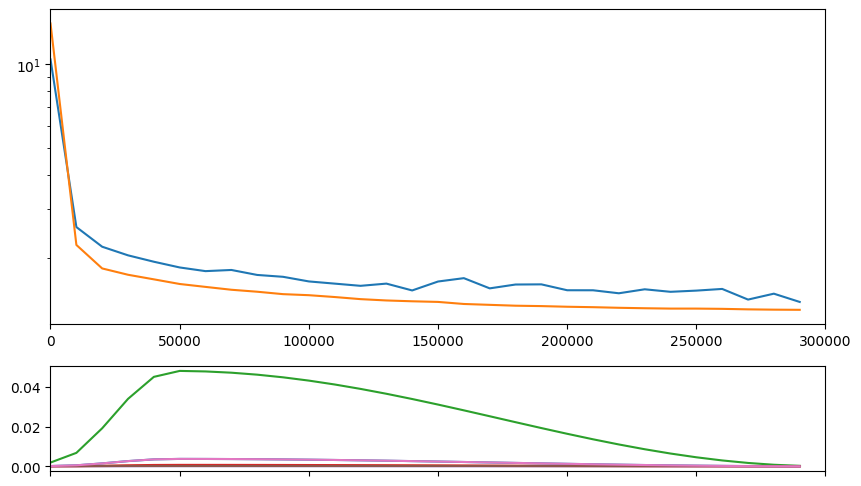

In [ ]:
# baseline
train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('tiny', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0/2, epochs=2,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50016,1.92771,2.02235,01:23
100000,1.43315,1.58909,02:48
150016,1.19694,1.22153,04:12
200000,1.08593,1.11246,05:36
250016,1.08340,1.04531,07:00
300000,1.02086,1.01358,08:24
350016,1.01914,0.99932,09:49
379968,1.07987,0.99130,10:39


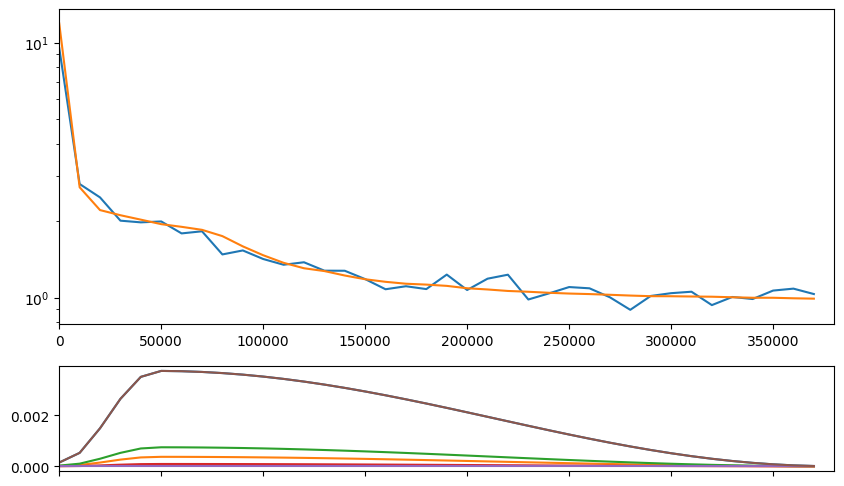

In [ ]:
# baseline
# train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('tiny', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0/2, epochs=2,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50016,1.78109,1.67754,02:05
100000,1.86647,1.50500,04:10
150016,1.66956,1.40646,06:15
200000,1.48269,1.35387,08:21
250016,1.44419,1.31720,10:26
299968,1.47340,1.30115,12:31


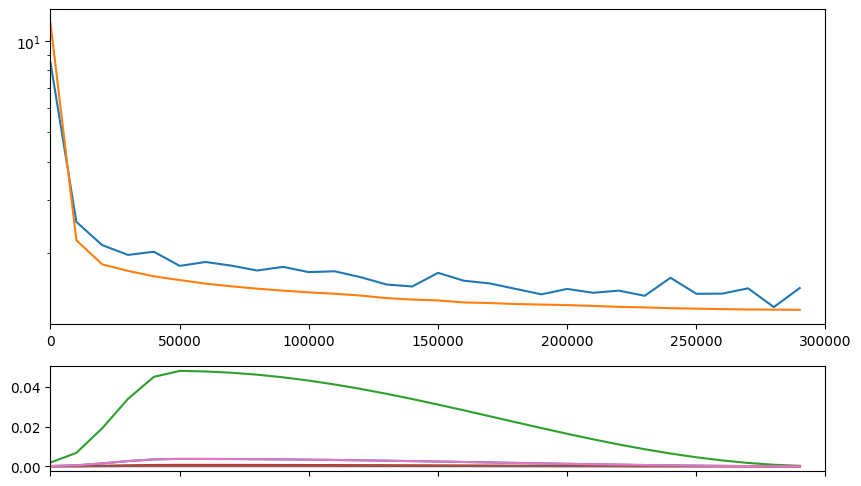

In [ ]:
# baseline + causal encoder
train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('tiny', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0/2, epochs=2,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50016,2.90977,2.62941,02:07
100000,2.21458,2.06109,04:13
150016,1.66289,1.63312,06:19
200000,1.72132,1.50796,08:26
250016,1.64924,1.44136,10:32
299968,1.70916,1.41862,12:37


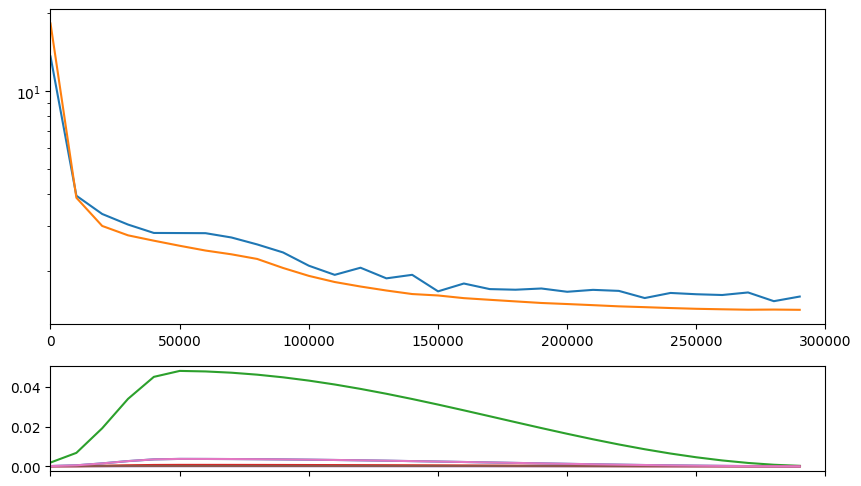

In [ ]:
# baseline + causal encoder + encoder next token prediction
train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('tiny', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0/2, epochs=2,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50016,2.55960,1.67898,02:07
100000,2.27045,1.33314,04:13
150016,1.86790,1.03826,06:19
200000,1.60350,0.94349,08:25
250016,1.59656,0.90378,10:31
299968,1.81595,0.88994,12:37


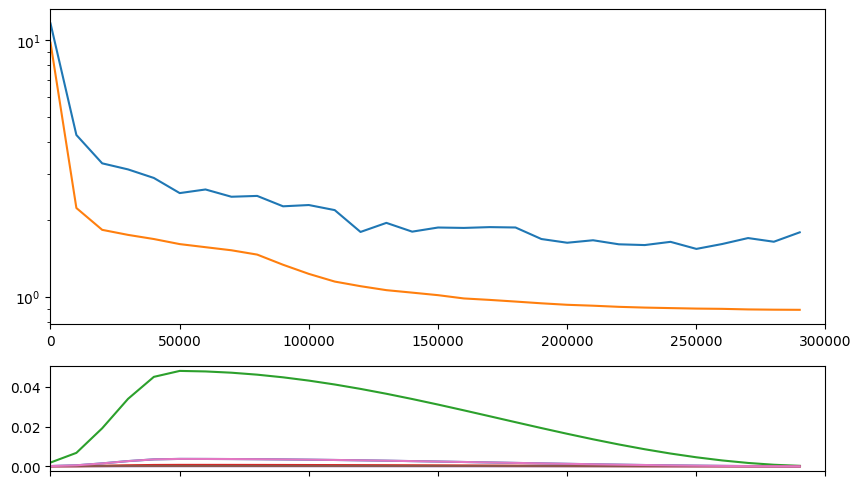

In [ ]:
# baseline + causal encoder + encoder next token prediction
train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('tiny', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0/2, epochs=2,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50016,2.30464,1.56358,03:20
100000,1.72967,0.93605,06:27
150016,1.38447,0.84605,09:34
200000,1.45703,0.80012,12:40
250016,1.46006,0.77872,15:47
300000,1.41666,0.75976,18:54
350016,1.39032,0.74583,22:01
400000,1.41846,0.73250,25:07
450016,1.38481,0.72326,28:15
500000,1.43020,0.72691,31:21


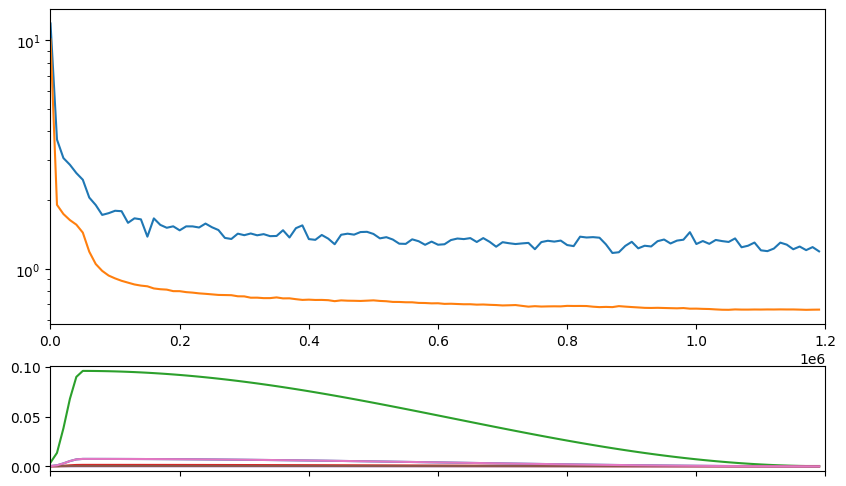

In [ ]:
# baseline + causal encoder + encoder next token prediction
train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('base', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

samples,train,val,time
50016,1.77722,1.56204,03:07
100000,1.08727,0.95343,06:13
150016,1.03234,0.85848,09:20
200000,1.03775,0.81874,12:26
250016,1.01491,0.78222,15:33
300000,0.98004,0.76420,18:40
350016,0.90916,0.75254,21:47
400000,0.92307,0.74475,24:54
450016,0.91725,0.73827,28:01
500000,0.84421,0.73274,31:08


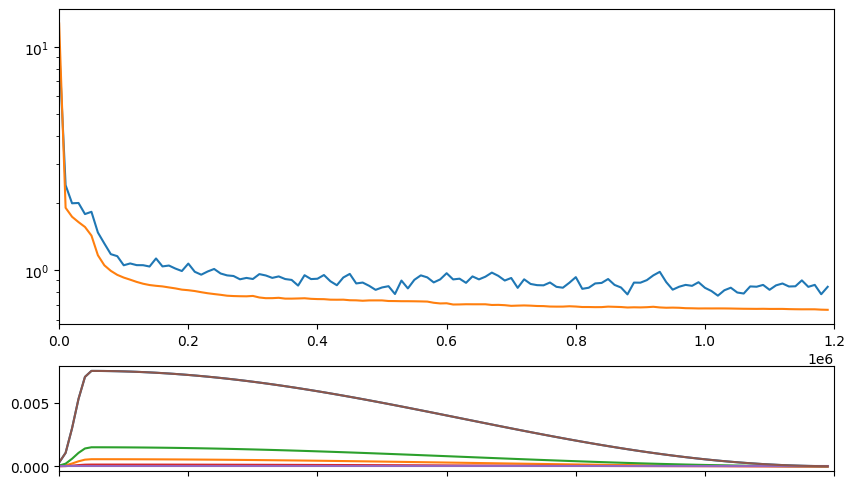

In [ ]:
# baseline + causal encoder + encoder next token prediction
# train_ds, val_ds = load_datasets('librilight-mlang-t2s/*.tar.gz', 150000, vq_codes=512+1)
model = make_model('base', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model', tunables=Tunables(weight_decay=1e-3, encoder_depth_ratio=.5, embedding_projector_lr_scale=5, cps_input=True)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=8,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=50000, run_valid_every_iters=10000)

In [ ]:
model.save_model('t2s-.1enclm-base.model')